# Introduction

Given samples of marginals $X\sim \mu$ and $Y \sim \nu$, we would like to find the solution of the Monge-Kantorovich problem
\begin{eqnarray}
\label{eq:pi_opt}
\pi^{\textrm{opt}}_{\mu,\nu}&:=& argmin_{\pi\in\Pi(\mu,\nu)}\int_{\mathbb{R}^{n}\times \mathbb{R}^{n}} c(x,y)\pi(dx,dy)
\end{eqnarray}
with $c:\mathbb{R}^{2n}\to\mathbb{R}$ as a non-negative smooth function. In this work, we use the orthogonal coupling dynamics of the form

\begin{eqnarray}
\label{eq:main-ODE}
\dot{X}_t=-\nabla_x c(X_t,Y_t)+\mathbb{E}_{p_t}[\nabla_x c(X_t,Y_t)|X_t] \nonumber \\
\textrm{and} \ \ \ \ \dot{Y}_t=-\nabla_y c(X_t,Y_t)+\mathbb{E}_{p_t}[\nabla_y c(X_t,Y_t)|Y_t].
\end{eqnarray}

In this notebook, we present how our implementation of OCD can be used.

# Map between Normal and Swiss-Roll distributions
First, we import libraries needed for OCD:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.append(src_path)
from OCD import *

rng = np.random.seed(0)

Next, we generate samples for our test case:

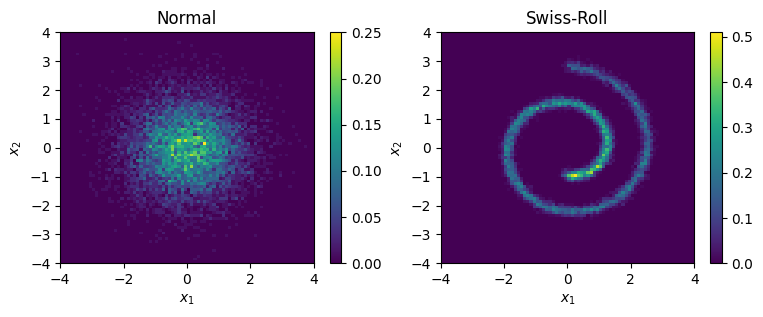

In [26]:
def swissroll(n=1000, noise=0.5):
    """
    Generate samples of a 2D Swiss roll distribution.

    Parameters:
    n (int)     : Number of points to generate (default: 1000)
    noise (float): Amount of Gaussian noise to add (default: 0.05)

    Returns:
    X (ndarray)  : An n x 2 matrix, where each row is a point (x, y) in 2D space
    """
    # Generate random values for the angle (theta) and height (z)
    theta = (3 * np.pi / 2) * (1 + 2 * np.random.rand(n, 1))  # Angle (theta) values for the spiral

    # Generate the (x, y) coordinates
    x = theta * np.cos(theta)
    y = theta * np.sin(theta)

    # Add Gaussian noise
    x += noise * np.random.randn(n, 1)
    y += noise * np.random.randn(n, 1)

    # Combine the coordinates into a matrix X
    X = np.hstack((x / 5., y / 5.))  # Dividing by 5 to match the scale

    return X

Np = 10**4 # number of points/particles/samples
dim = 2

X = np.random.normal(0,1,(Np,dim))
Y = swissroll(Np)

## store samples for future use
Y00 = Y.copy()
X00 = X.copy()

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

h1 = axes[0].hist2d(X[:,0],X[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
axes[0].set_title("Normal")
axes[0].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")
fig.colorbar(h1[-1], ax=axes[0])  # Add colorbar for the first plot

h2 = axes[1].hist2d(Y[:,0],Y[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
axes[1].set_title("Swiss-Roll")
axes[1].set_xlabel(r"$x_1$")
axes[1].set_ylabel(r"$x_2$")
fig.colorbar(h2[-1], ax=axes[1])  # Add colorbar for the first plot

# Solve OT using OCD

epsilon =  0.026826957952797246


Text(0.5, 0, 'Iteration')

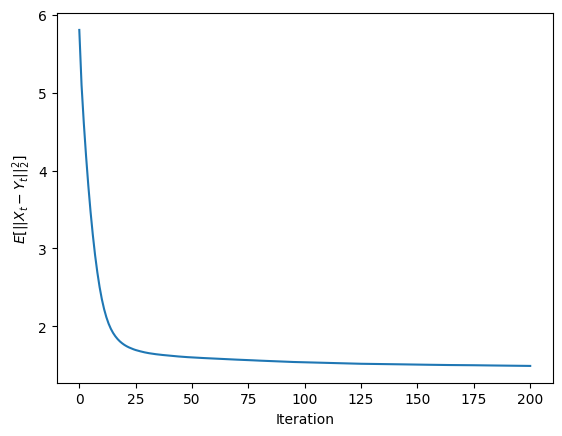

In [3]:
X0 = X00.copy()
Y0 = Y00.copy()

eps0 = find_opt_eps2(X0, Y0, log_eps_range=[-3,0], nepss = 400, perc=0.9998)
print("epsilon = ", eps0)

dt = 0.1
Nt = 200
tol = 1e-6

X_ocd, Y_ocd, dists, err_m2X, err_m2Y = ocd_map_RK4(X0, Y0, dt=dt, Nt=200, sigma=eps0, tol=tol)

plt.figure()
plt.plot(dists)
plt.ylabel(r"$E[||X_t-Y_t||_2^2]$")
plt.xlabel("Iteration")   

# Solve OT using EMD

In [4]:
## Load libraries
! pip3 install POT
import ot

def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

In [6]:
x_emd = X0.copy()
y_emd = Y0.copy()
x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)

# Compare found opitmal pairing

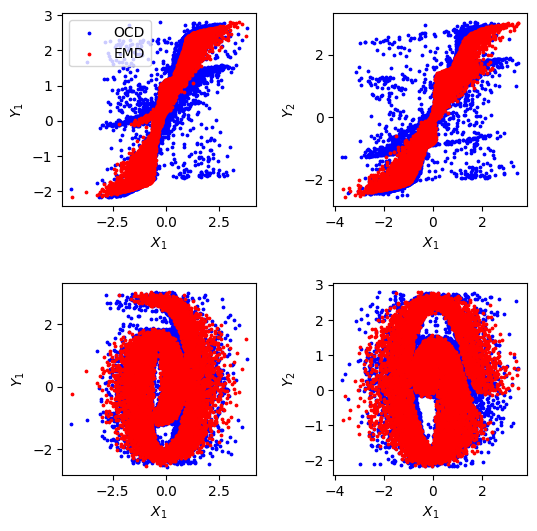

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

axes[0,0].scatter(X_ocd[:,0], Y_ocd[:,0], color="blue", s=3, label="OCD")
axes[0,0].scatter(x_emd[:,0], y_emd[:,0], color="red", s=3, label="EMD")
axes[0,0].set_xlabel(r"$X_1$")
axes[0,0].set_ylabel(r"$Y_1$")

axes[0,1].scatter(X_ocd[:,1], Y_ocd[:,1], color="blue", s=3)
axes[0,1].scatter(x_emd[:,1], y_emd[:,1], color="red", s=3)
axes[0,1].set_xlabel(r"$X_1$")
axes[0,1].set_ylabel(r"$Y_2$")

axes[1,0].scatter(X_ocd[:,0], Y_ocd[:,1], color="blue", s=3)
axes[1,0].scatter(x_emd[:,0], y_emd[:,1], color="red", s=3)
axes[1,0].set_xlabel(r"$X_1$")
axes[1,0].set_ylabel(r"$Y_1$")

axes[1,1].scatter(X_ocd[:,1], Y_ocd[:,0], color="blue", s=3)
axes[1,1].scatter(x_emd[:,1], y_emd[:,0], color="red", s=3)
axes[1,1].set_xlabel(r"$X_1$")
axes[1,1].set_ylabel(r"$Y_2$")

axes[0,0].legend()
fig.subplots_adjust(wspace=0.4, hspace=0.4)

# Learn the continuous map using PyTorch
Now that have found paired particles $(X^*,Y^*)$, we train a network as a super-wise learning.

Epoch 1000, Loss: 0.5421662330627441
Epoch 2000, Loss: 0.44441404938697815
Epoch 3000, Loss: 0.3071020245552063
Epoch 4000, Loss: 0.21286527812480927
Epoch 5000, Loss: 0.15338855981826782
Epoch 6000, Loss: 0.11988218873739243
Epoch 7000, Loss: 0.09214474260807037
Epoch 8000, Loss: 0.07787306606769562
Epoch 9000, Loss: 0.06326214224100113
Epoch 10000, Loss: 0.05325090512633324


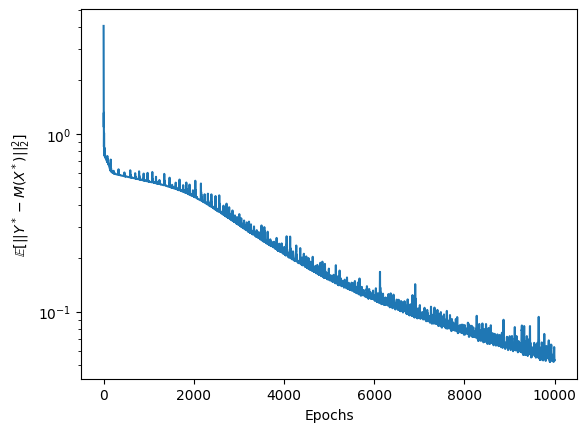

In [10]:
import torch
from torch import nn, optim

class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss

# Convert numpy array to pytorch tensors first
X = torch.tensor(X_ocd, dtype=torch.float32)
Y = torch.tensor(Y_ocd, dtype=torch.float32)

# Create NN by instantiating the model class
M = Model(input_dim=2)

# Set the optimizaiton method and learning rate
optimizer = optim.Adam(M.parameters(), lr=5e-3)

# Training loop
n_epochs = 10000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = M.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

M.eval()

# plot the training loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel(r"$\mathbb{E}[||Y^*-M(X^*)||_2^2]$")
plt.yscale("log")

Now, we can test the learned map $M:X\rightarrow Y$ by sampling $X$ (Gaussian) and checking density of $Y$ (Swiss roll).

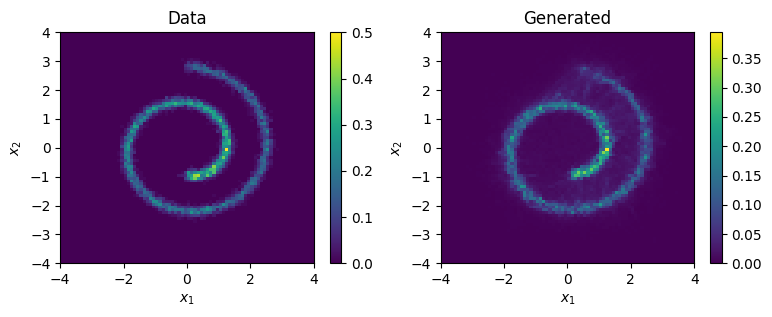

In [24]:
# generate testing samples
Xtest = np.random.normal(0,1,(10**6,2))
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = M.forward(Xtest).detach().numpy()

fig, axes = plt.subplots(1, 2, figsize=(9, 3))

h1 = axes[0].hist2d(Y00[:,0],Y00[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
axes[0].set_title("Data")
axes[0].set_xlabel(r"$x_1$")
axes[0].set_ylabel(r"$x_2$")
fig.colorbar(h1[-1], ax=axes[0])  # Add colorbar for the first plot

h2 = axes[1].hist2d(Ytest[:,0],Ytest[:,1],bins=80, range=[[-4,4],[-4,4]], density=True)
axes[1].set_title("Generated")
axes[1].set_xlabel(r"$x_1$")
axes[1].set_ylabel(r"$x_2$")
fig.colorbar(h2[-1], ax=axes[1])  # Add colorbar for the first plot